In this part 2, we will use our trained car non-car classifer to detect car using sliding window. The process is follows:
*  Train/Load trained SVM classifier.
*  Make a Detector with sliding window.



In [1]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from skimage import feature, exposure
import imutils
from sklearn.svm import LinearSVC
from imutils.object_detection import non_max_suppression

In [2]:
!cp /content/drive/MyDrive/Datasets/car-noncars.zip /content/
!unzip --qq /content/car-noncars.zip

## Make Dataset

In [4]:
p1 = "/content/VehicleImage/non-vehicles/MiddleClose/"
p2 = "/content/VehicleImage/vehicles/MiddleClose/"

non_cars_paths = [p1+i for i in os.listdir(p1)][:500]
cars_paths = [p2+i for i in os.listdir(p2)][:500]

images_path = non_cars_paths + cars_paths
labels = [0]*len(non_cars_paths) + [1]*len(cars_paths) # non cars 0 and cars 1

X_train, X_test, Y_train, Y_test = train_test_split(images_path, labels, test_size= 0.3)

print('Total Train samples:', len(Y_train))
print('Total Test samples:', len(Y_test))

Total Train samples: 700
Total Test samples: 300


## Train SVMs on HOG features

In [5]:
def get_hog_feaures(image):
  # image values is already normalized under hog function
  Hog_features = feature.hog(image, orientations=9, 
                          pixels_per_cell=(8,8), cells_per_block=(2,2), 
                            feature_vector=True)
  return Hog_features

In [6]:
# read image, get HOG features 

train_features = []

for image in X_train: 
  image = cv2.imread(image, cv2.COLOR_BGR2GRAY)
  hog_features = get_hog_feaures(image)
  train_features.append(hog_features)  

In [8]:
# train a svm on them

svc = LinearSVC(tol=0.0001, random_state=42)
svc = svc.fit(train_features, Y_train)

Make detector with sliding window

In [ ]:
DIR = '/content/drive/MyDrive/photos/'

def sliding_window(image, stride, windowSize): 
  # taken from pyimagesearch
	# slide a window across the image
	for y in range(0, image.shape[0], stride):
		for x in range(0, image.shape[1], stride):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
   
def pyramid(image, scale=1.5, pyr_level = 3):
  # taken from pyimagesearch
	# yield the original image

	yield image
	# keep looping over the pyramid
	for i in range(pyr_level):
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# yield the next image in the pyramid
		yield image

def detect_car(image):
    rects = []
    offset = int(image.shape[0]/2) # to miss the sky, start from half row of the image
    new_img = image[offset:, :] 
    gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    # apply pyramids
    for img in pyramid(gray, pyr_level = 3):
       for (x, y, window) in sliding_window(img, stride=20, windowSize=(64, 64)):
          if window.shape[0] != 64 or window.shape[1] != 64:
	          continue
          feature = get_hog_feaures(window)  
          yhat = svc.predict((feature).reshape(1, feature.shape[0]))
          if yhat == 1:
              rects.append([x, y, x+64, y+64]) # collect all rects which have cars 

    # apply non-max suppression 
    final_boxes = non_max_suppression(np.array(rects), overlapThresh=0.2)
    for (x1,y1,x2,y2) in final_boxes:
        cv2.rectangle(image, (x1, y1+ offset), (x2, y2+ offset), (0,255,0), 2)   
    return image

for i, image in enumerate(os.listdir(DIR)):
  if i == 12:
    image = cv2.imread(DIR + image)
    image = imutils.resize(image, width=400)
    img = detect_car(image)
    break 
print('Done')

Done


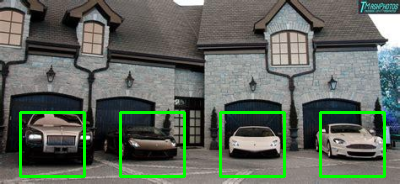

In [ ]:
Image.fromarray(img)

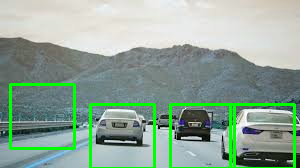

In [ ]:
Image.fromarray(img)

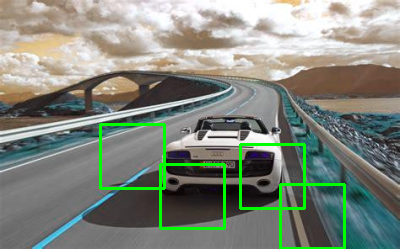

In [ ]:
Image.fromarray(img)

**Summary**: As in part 2 the results weren't that satisfying but still managable and there is plenty room for improvements. Using sliding window, image pyramids and non-max supperession we contructed an classic object detector using HOG+SVM. One problem I faced was the boxes, the aspect ratio of box is 64*64, which is not sufficient for image with huge cars object, and with small objects the boxes stay large(if object is small but still detected), with known pyr scaler ratio it might be fixed. we can resize the image before inputing it to the detector but still it needs some improvements. 

Improvements:
* Variable sizes of boxes.
* Solution for bigger objects(more than 64*64 res car dataset)
* Neat sliding window implementation.
* Use another algorithm with predict_proba and set some thershold.

